In [68]:
%pip install --upgrade pip
%pip install pytorch
%pip install torchvision
%pip install opencv-python
%pip install matplotlib
%pip install scikit-image
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pytorch (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [37 lines of output]
      Traceback (most recent call last):
        File "/Users/7n100489/Library/CloudStorage/OneDrive-BankofAyudhyaPublicCompanyLimited/Desktop/Workspace/github/kmitl-image-processing/.venv/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "/Users/7n100489/Library/CloudStorage/OneDrive-BankofAyudhyaPublicCompanyLimited/Desktop/Workspace/github/kmitl-image-processing/.venv/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
         

# **Lab 4.1 Data Augmentation with PyTorch**

In [69]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [ ]:
def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Pad(10),
            transforms.RandomAffine(
                degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=45
            ),
            transforms.CenterCrop(200),
        ]
    )

    dataset = ImageFolder(path, transform=transform)

    print("📃Train Dataset:")
    for idx, class_name in enumerate(dataset.classes):
        class_size = len([img for img, label in dataset.imgs if label == idx])
        print(f"\tNumber of images in class {class_name}: {class_size}")

    print(f"\tNumber of samples: {len(dataset)}")

    data_loader = DataLoader(
        dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True
    )

    # show first batch of images
    images, labels = next(iter(data_loader))
    print(f"First batch of images shape: {images.shape}")
    

    return data_loader

    ### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/01.png?raw=true)

</details>

In [71]:
def show_first_batch_image(data_loader):
    images, labels = next(iter(data_loader))
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(len(images)):
        axs[i // 4, i % 4].imshow(images[i].permute(1, 2, 0))
        axs[i // 4, i % 4].set_title(f"Label: {labels[i].item()}")
        axs[i // 4, i % 4].axis("off")
    plt.tight_layout()
    plt.show()

📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
First batch of images shape: torch.Size([16, 3, 200, 200])


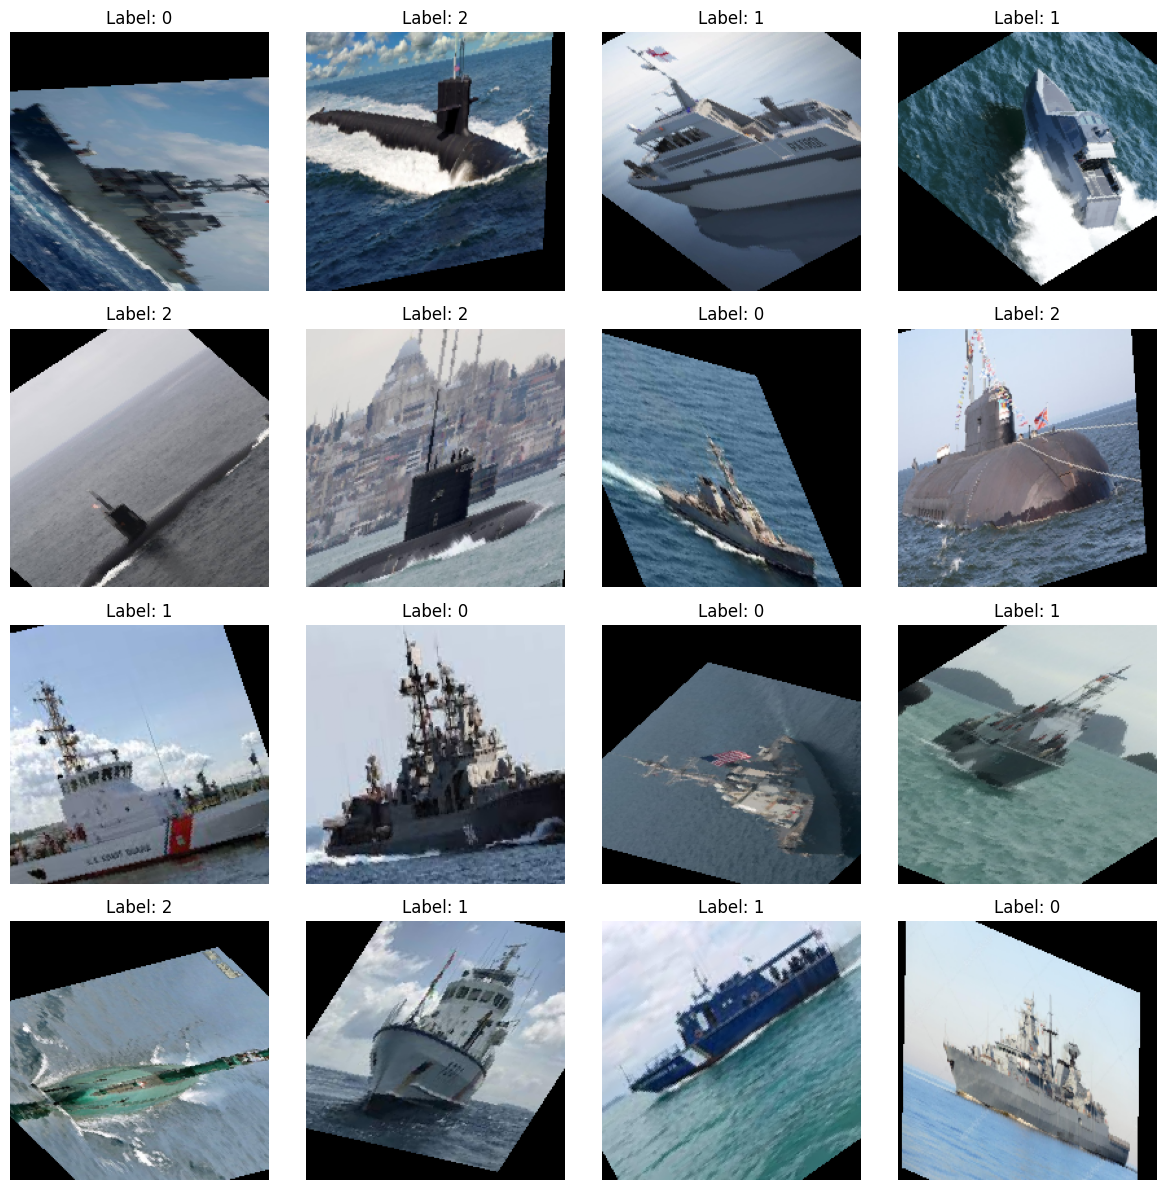

In [72]:
### START CODE HERE ###
data_loader = load_data("./Ship/Train")

show_first_batch_image(data_loader)
### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [96]:
from PIL import Image


class CustomImageDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.classes = os.listdir(path)
        self.image_paths = []
        self.labels = []

        print("Classes found:", self.classes)
        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(path, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
                        self.image_paths.append(os.path.join(class_dir, file_name))
                        self.labels.append(label_idx)

        print("self.image_paths:", self.image_paths)
        print("self.labels:", self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        image = self.transform_image(image)

        return image, label

    def transform_image(self, image):
        image = transforms.Resize((224, 224))(image)
        image = transforms.ToTensor()(image)
        image = transforms.Pad(200, padding_mode="reflect")(image)
        image = transforms.RandomAffine(
            degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=45
        )(image)
        image = transforms.CenterCrop(200)(image)

        # random add noise and blur
        if random.random() < 0.5:  # 50% chance to add
            image = self.add_gaussian_noise(image)
        if random.random() < 0.5:
            image = self.add_gaussian_blur(image)

        return image

    def add_gaussian_noise(self, image, mean=0, var=0.01):
        noise = random_noise(image.numpy(), mode="gaussian", var=var, mean=mean)
        return torch.tensor(noise).float()

    def add_gaussian_blur(self, image):
        kernel_size = random.choice([3, 5, 7])
        blur_transform = transforms.GaussianBlur(
            kernel_size=kernel_size, sigma=(0.1, 2.0)
        )
        return blur_transform(image)


Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/02.png?raw=true)

</details>

Classes found: ['patrol boat', 'battleship', 'submarine']
self.image_paths: ['./Ship/Train/patrol boat/p12.jpg', './Ship/Train/patrol boat/p13.jpg', './Ship/Train/patrol boat/p11.jpg', './Ship/Train/patrol boat/p28.jpg', './Ship/Train/patrol boat/p14.jpg', './Ship/Train/patrol boat/p15.jpg', './Ship/Train/patrol boat/p29.jpg', './Ship/Train/patrol boat/p16.jpg', './Ship/Train/patrol boat/p9.jpg', './Ship/Train/patrol boat/p8.jpg', './Ship/Train/patrol boat/p3.jpg', './Ship/Train/patrol boat/p2.jpg', './Ship/Train/patrol boat/p1.jpg', './Ship/Train/patrol boat/p5.jpg', './Ship/Train/patrol boat/p4.jpg', './Ship/Train/patrol boat/p6.jpg', './Ship/Train/patrol boat/p7.jpg', './Ship/Train/patrol boat/p27.jpg', './Ship/Train/patrol boat/p33.jpg', './Ship/Train/patrol boat/p32.jpg', './Ship/Train/patrol boat/p26.jpg', './Ship/Train/patrol boat/p30.jpg', './Ship/Train/patrol boat/p24.jpg', './Ship/Train/patrol boat/p18.jpg', './Ship/Train/patrol boat/p19.jpg', './Ship/Train/patrol boat/p25.jp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.020815587..1.0000002].


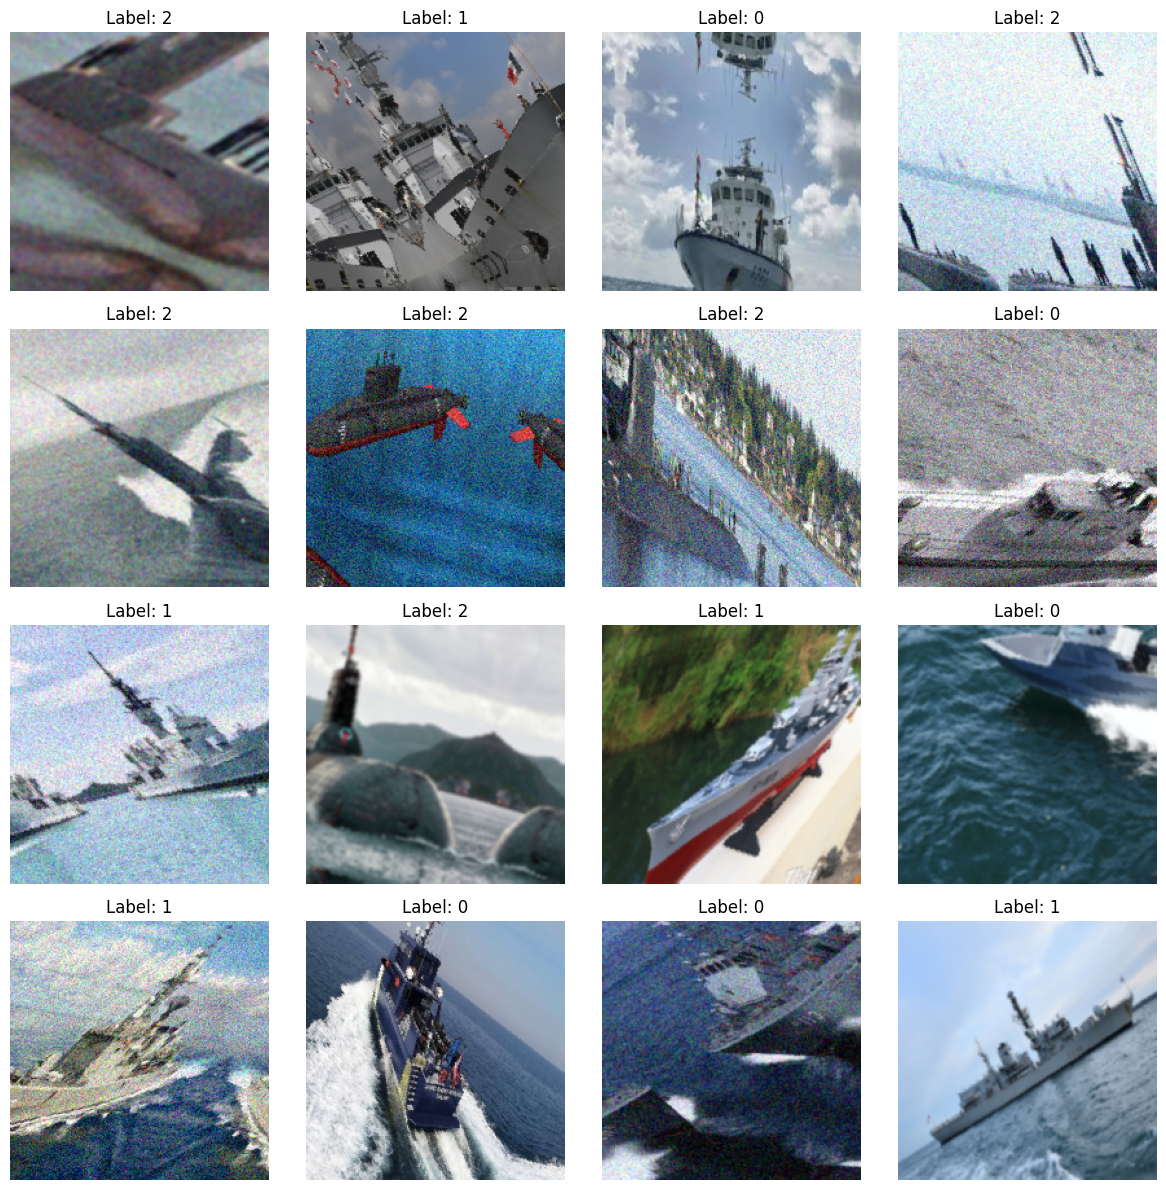

In [ ]:
### START CODE HERE ###
dataset = CustomImageDataset("./Ship/Train")
dataloader = DataLoader(
    dataset=dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True
)

show_first_batch_image(dataloader)

### END CODE HERE ###

Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?

1. Using padding in CNNs preserves the input size, ensuring that spatial dimensions remain unchanged. It is particularly effective for capturing edge features, as it allows convolutional filters to process border information more accurately.
2. The amount of data augmentation should strike a balance between enhancing generalization and preserving the core patterns in the original data. However, the optimal amount varies depending on the specific context and use case.
3. Randomly change a portion of image pixels to black (0) or white (255), simulating sharp disturbances.
4. Blur -> GausianBlur, Scale -> RandomResizedCrop, Contrast and Brightness -> ColorJitter